In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [4]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2021-10-08 13:45:44.449506: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-10-08 13:45:44.449644: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.4.1


In [5]:
pd.set_option('display.max_columns', 90)
#pd.set_option('display.max_rows', None)

In [6]:
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

In [7]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [9]:
train.shape 

(1460, 81)

<AxesSubplot:>

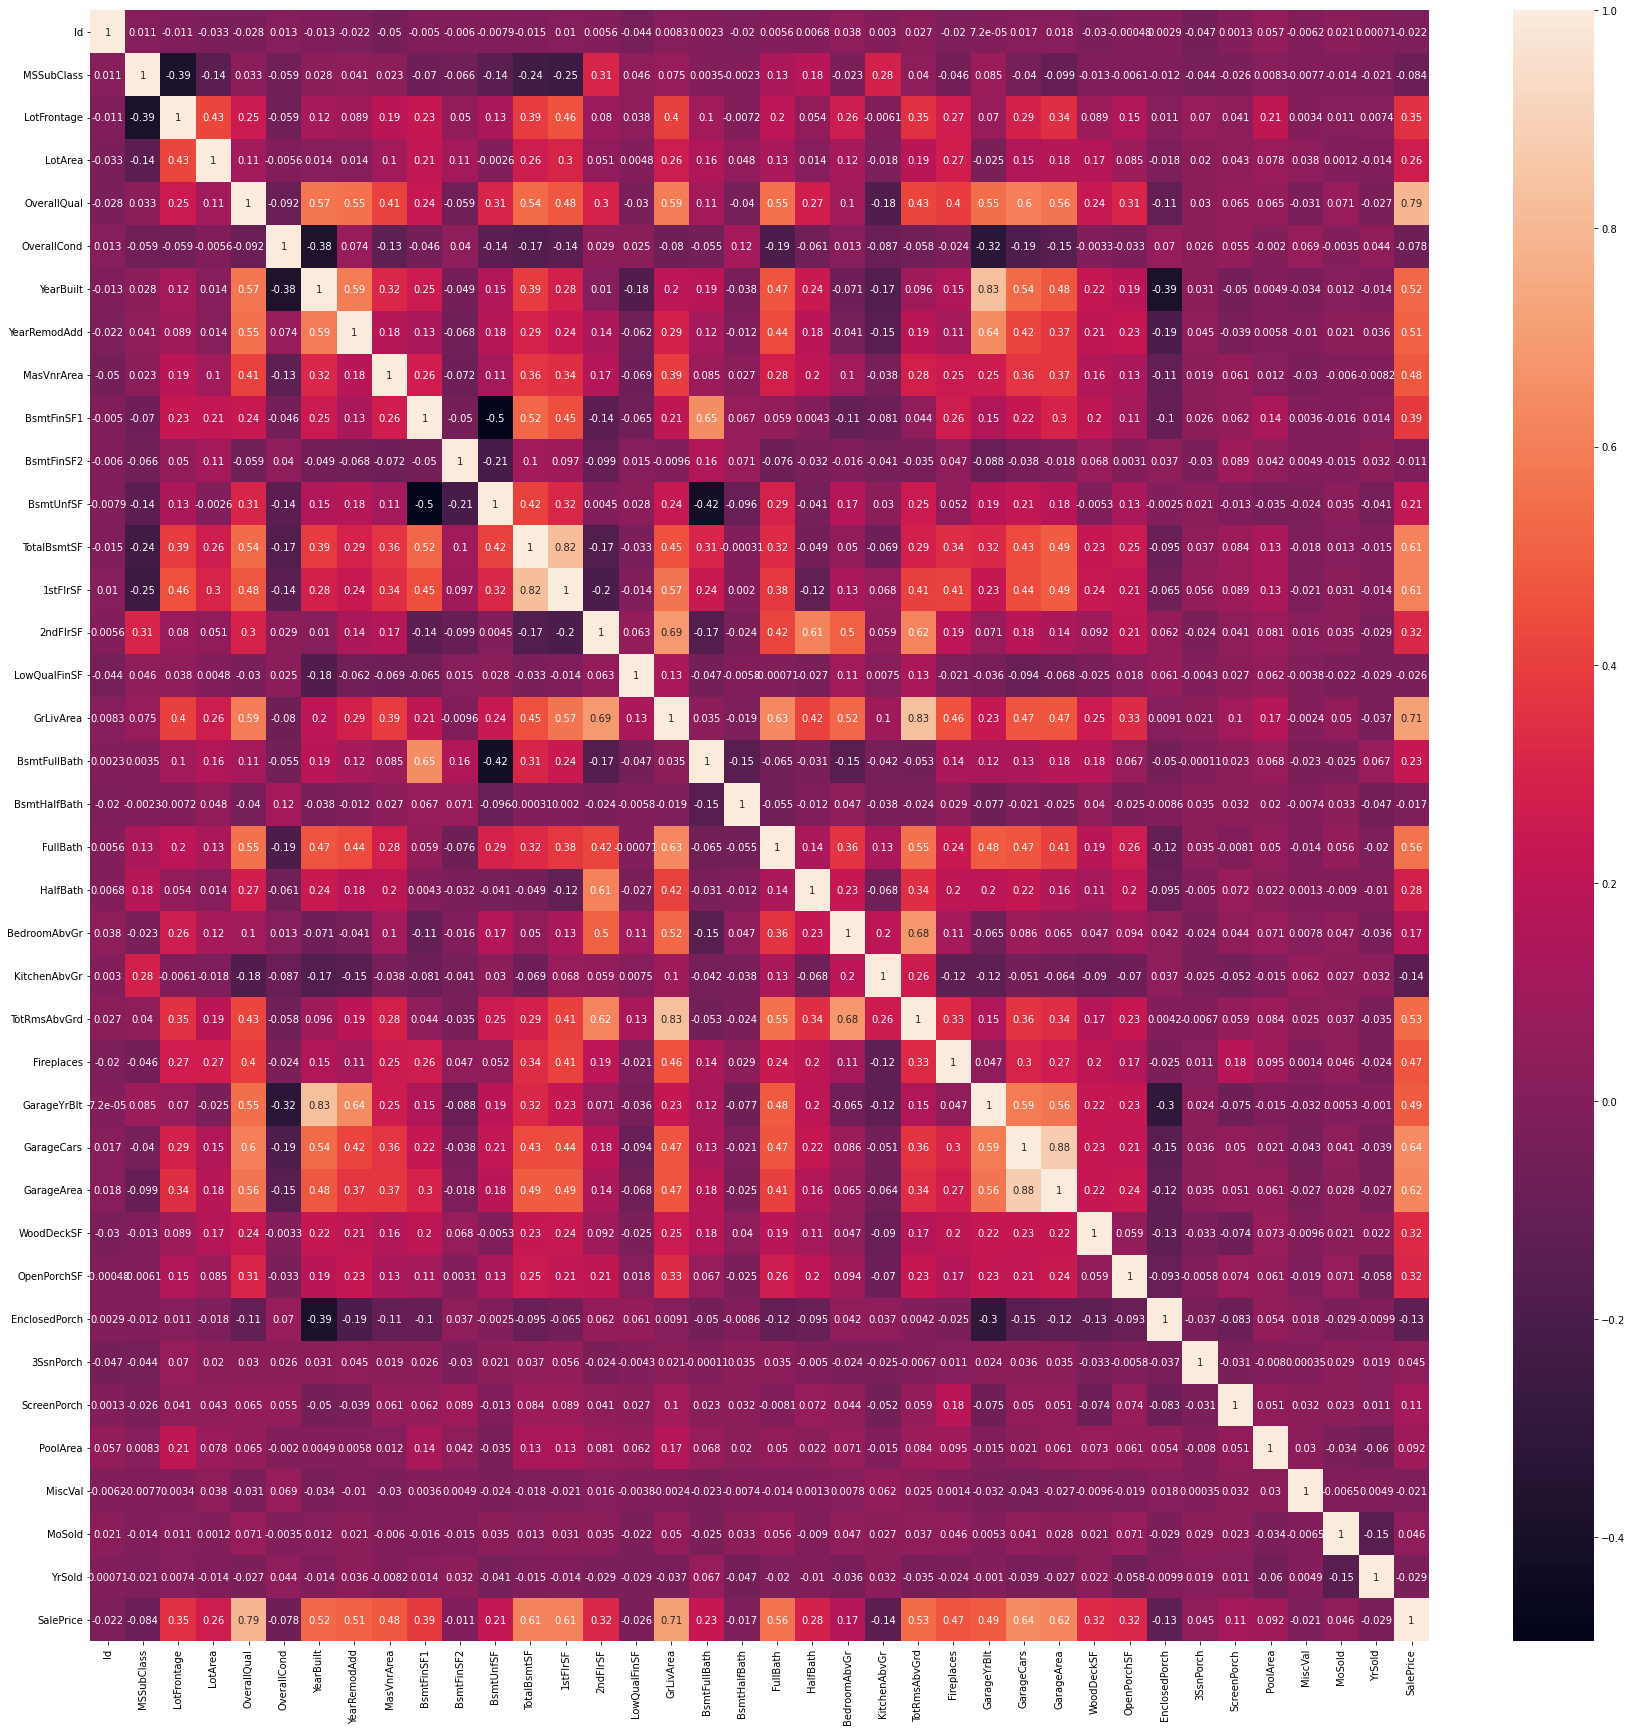

In [10]:
plt.figure(figsize=([30,30]))
sns.heatmap(train.corr(), annot=True)

In [11]:
train_Id= train['Id']
test_Id = test['Id']

del train['Id']
del test['Id']

In [12]:
# Split X and y (in df dataset)
X = train.drop('SalePrice', axis=1)
y = train['SalePrice'].to_frame()



In [13]:
X.shape , y.shape

((1460, 79), (1460, 1))

In [14]:
# Add variable
X['train'] = 1
test['train'] = 0

# Combining df and test for data cleaning 
df = pd.concat([test, X])

In [15]:
df.shape

(2919, 80)

In [16]:
drop_cols = ['YrSold','MiscVal','EnclosedPorch','LowQualFinSF','MSSubClass']
df = df.drop(columns = drop_cols)
df = df.drop(columns=['PoolQC','MiscFeature','Alley','Fence'])
df = df.drop(columns=['Electrical'])

In [17]:
df.shape, df.shape

((2919, 70), (2919, 70))

In [18]:
df.head()

,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,3SsnPorch,ScreenPorch,PoolArea,MoSold,SaleType,SaleCondition,train
0,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,896,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,120,0,6,WD,Normal,0
1,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,1329,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,6,WD,Normal,0
2,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,928,701,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,3,WD,Normal,0
3,RL,78.0,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,926,678,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,6,WD,Normal,0
4,RL,43.0,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,1280,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,144,0,1,WD,Normal,0


In [19]:
df.isna().sum().sort_values(ascending=False).head(10)

FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageQual       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
dtype: int64

# Removing missing values

In [20]:
df['MasVnrType'] = df['MasVnrType'].fillna('None')
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)
df['FireplaceQu'] = df['FireplaceQu'].fillna('None')
df['LotFrontage'] =df['LotFrontage'].fillna(0)
df['MSZoning'] = df['MSZoning'].fillna('None')
df['Utilities'] = df['Utilities'].fillna('None')
df['Functional'] = df['Functional'].fillna('None')
df['KitchenQual'] = df['KitchenQual'].fillna('None')
df['Exterior2nd'] = df['Exterior2nd'].fillna('None')
df['Exterior1st'] = df['Exterior1st'].fillna('None')
df['TotalBsmtSF'] = df['TotalBsmtSF'].fillna(0)
df['SaleType'] = df['SaleType'].fillna('None')

col_garage = [col for col in df if col.startswith('Garage')]
for i in df[col_garage].select_dtypes(exclude='object').columns:
    df[i] = df[i].fillna(0)
    
for i in df[col_garage].select_dtypes(include='object').columns:
    df[i] = df[i].fillna('None')
    
col_bsnmt = [col for col in df if col.startswith('Bsmt')]
for i in df[col_bsnmt].select_dtypes(exclude='object').columns:
    df[i] = df[i].fillna(0)

for i in df[col_bsnmt].select_dtypes(include='object').columns:
    df[i]=df[i].fillna('None')

In [21]:
df.head()

,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,3SsnPorch,ScreenPorch,PoolArea,MoSold,SaleType,SaleCondition,train
0,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,896,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,None,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,120,0,6,WD,Normal,0
1,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,1329,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,None,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,6,WD,Normal,0
2,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,928,701,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,3,WD,Normal,0
3,RL,78.0,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,926,678,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,6,WD,Normal,0
4,RL,43.0,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,1280,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,None,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,144,0,1,WD,Normal,0


In [22]:
df.isna().sum().sort_values(ascending=False).head(10)

MSZoning        0
FullBath        0
Functional      0
TotRmsAbvGrd    0
KitchenQual     0
KitchenAbvGr    0
BedroomAbvGr    0
HalfBath        0
BsmtHalfBath    0
FireplaceQu     0
dtype: int64

In [23]:
df.shape, test.shape

((2919, 70), (1459, 80))

In [24]:
df.dtypes

MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
LotShape          object
                  ...   
PoolArea           int64
MoSold             int64
SaleType          object
SaleCondition     object
train              int64
Length: 70, dtype: object

In [25]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
LotFrontage,2919.0,57.766701,33.481636,0.0,43.0,63.0,78.0,313.0
LotArea,2919.0,10168.114080,7886.996359,1300.0,7478.0,9453.0,11570.0,215245.0
OverallQual,2919.0,6.089072,1.409947,1.0,5.0,6.0,7.0,10.0
OverallCond,2919.0,5.564577,1.113131,1.0,5.0,5.0,6.0,9.0
YearBuilt,2919.0,1971.312778,30.291442,1872.0,1953.5,1973.0,2001.0,2010.0
YearRemodAdd,2919.0,1984.264474,20.894344,1950.0,1965.0,1993.0,2004.0,2010.0
MasVnrArea,2919.0,101.396026,178.854579,0.0,0.0,0.0,163.5,1600.0
BsmtFinSF1,2919.0,441.272011,455.606014,0.0,0.0,368.0,733.0,5644.0
BsmtFinSF2,2919.0,49.565262,169.179104,0.0,0.0,0.0,0.0,1526.0
BsmtUnfSF,2919.0,560.579993,439.590889,0.0,220.0,467.0,805.0,2336.0


SKEW


In [26]:
resp = y.SalePrice
from scipy.stats import shapiro

shapiro(resp)[1]

3.206247534576162e-33

In [27]:
#num_feats = df.select_dtypes(exclude='object').columns

In [28]:
#skew_feats = df[num_feats].skew().sort_values(ascending=False)
#skewness = pd.DataFrame({'skew':skew_feats})

In [29]:
y['SalePrice'] = np.log(y['SalePrice'])

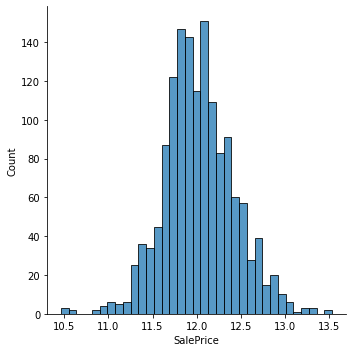

In [30]:
sns.displot(y['SalePrice'])

In [31]:
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
#for col in skewness.index:
#    df[col] = boxcox1p(df[col], boxcox_normmax(df[col] + 1))

# Removing Categorical values

In [32]:
s = (df.dtypes == 'object')
object_cols = list(s[s].index)
print(object_cols)

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


In [33]:
df = pd.get_dummies(df , columns=object_cols , drop_first=True)
#test = pd.get_dummies(test, columns=object_cols1,drop_first=True)

In [34]:
df.shape , test.shape

((2919, 245), (1459, 80))

In [35]:
df.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,3SsnPorch,ScreenPorch,PoolArea,MoSold,train,MSZoning_FV,MSZoning_None,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,...,Functional_Min2,Functional_Mod,Functional_None,Functional_Sev,Functional_Typ,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_None,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,882.0,896,0,896,0.0,0.0,1,0,2,1,5,0,1961.0,1.0,730.0,140,0,0,120,0,6,0,0,0,1,0,0,1,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,1329.0,1329,0,1329,0.0,0.0,1,1,3,1,6,0,1958.0,1.0,312.0,393,36,0,0,0,6,0,0,0,0,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,928.0,928,701,1629,0.0,0.0,2,1,3,1,6,1,1997.0,2.0,482.0,212,34,0,0,0,3,0,0,0,0,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,324.0,926.0,926,678,1604,0.0,0.0,2,1,3,1,7,1,1998.0,2.0,470.0,360,36,0,0,0,6,0,0,0,0,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,1017.0,1280.0,1280,0,1280,0.0,0.0,2,0,2,1,5,0,1992.0,2.0,506.0,0,82,0,144,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [36]:
X = df[df['train']==1]
X.shape

(1460, 245)

In [37]:
test = df[df['train']==0]
X.drop(['train'], axis=1, inplace=True)
test.drop(['train'], axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4908: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [38]:
test.shape

(1459, 244)

# Train test split

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state = 123)

In [41]:
normalize = preprocessing.Normalization(axis=-1)

In [42]:
normalize.adapt(np.array(X_train))

2021-10-08 13:46:03.483578: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-08 13:46:03.487113: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-10-08 13:46:03.487155: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-08 13:46:03.487190: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (2c5a72a53f8f): /proc/driver/nvidia/version does not exist
2021-10-08 13:46:03.488541: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

# Deep Neural Network Model

In [43]:
model = tf.keras.Sequential([
    normalize,
    layers.Dense(64,activation='relu'),
    #layers.Dropout(0.3),
    #layers.BatchNormalization(),
    layers.Dense(128,activation='relu'),
    #layers.Dropout(0.3),
    #layers.BatchNormalization(),
    layers.Dense(128,activation='relu'),
    #layers.Dropout(0.3),
    #layers.BatchNormalization(),
    layers.Dense(1)
    
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 244)               489       
_________________________________________________________________
dense (Dense)                (None, 64)                15680     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 41,130
Trainable params: 40,641
Non-trainable params: 489
_________________________________________________________________


In [44]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05),loss=['mae'])
history = model.fit(X_train,y_train,epochs=70,verbose=0,validation_split=0.2,batch_size=64)

2021-10-08 13:46:04.151168: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-08 13:46:04.166719: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200215000 Hz


,loss,val_loss
65,0.105512,0.256455
66,0.179580,0.219474
67,0.134983,0.200162
68,0.151797,0.162607
69,0.102006,0.143609


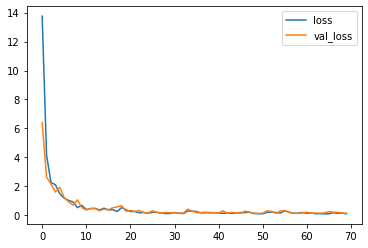

In [45]:
hist_df = pd.DataFrame(history.history)
hist_df[['loss','val_loss']].plot()
hist_df.tail()

In [46]:
test_result = {}
test_result['DNN'] = model.evaluate(X_test,y_test,verbose=0)
test_result

{'DNN': 533.9498901367188}

In [47]:
test_prediction = model.predict(test).flatten()

In [48]:
X_train.shape , test.shape, X_test.shape,y_train.shape,y_test.shape

((1022, 244), (1459, 244), (438, 244), (1022, 1), (438, 1))

# XG BOOST Model

In [49]:
XGB_model = XGBRegressor(n_estimators=500 , learning_rate = 0.2)

XGB_model.fit(X_train,y_train,
              early_stopping_rounds=5,
              eval_set=[(X_test,y_test)],
             verbose=False)

predictions_XGB = XGB_model.predict(test)
#print("Mean Absolute Error: " + str(mean_absolute_error(predictions_XGB, y_test)))
XGB_model.score(X_test,y_test)

0.8879726486977932

In [50]:
#print("Mean Absolute Error:" +str(mean_absolute_error(test_prediction,test_labels1)))

# Build Models for stacking


In [51]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score

**K nearest neighbours**

In [52]:
from sklearn.tree import DecisionTreeRegressor

Dt_model = DecisionTreeRegressor()
Dt_model.fit(X_train,y_train)

predictions_Dt = Dt_model.predict(test)

#print("Mean Absolute Error: " + str(mean_absolute_error(predictions_Dt, y_test)))
Dt_model.score(X_test,y_test)

0.7381393608714324

**Random Forest**

In [53]:
from sklearn.ensemble import RandomForestRegressor

RF_model = RandomForestRegressor()
RF_model.fit(X_train,y_train)

predictions_RF = RF_model.predict(test)

#print("Mean Absolute Error: " + str(mean_absolute_error(predictions_Dt, test)))
#predictions_RF.score(X_test,y_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [54]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

Ada_model = AdaBoostRegressor(random_state=50,learning_rate=0.02,n_estimators=100,base_estimator=ExtraTreesRegressor(random_state=100))
Ada_model.fit(X_train,y_train)

predict_Ada = Ada_model.predict(test)


#print("Mean Absolute Error: " + str(mean_absolute_error(predict_Ada, test_labels1)))
Ada_model.score(X_test,y_test)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.8781371605097074

# Buld Stacked Model

In [55]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

estimators =[('XGB_model',XGB_model),
            ('Ada_model',Ada_model)]

stack_model = StackingRegressor(estimators=estimators , final_estimator=RidgeCV())

stack_model.fit(X_train,y_train)

predictions_stack = stack_model.predict(test)

#print("Mean Absolute Error: " + str(mean_absolute_error(predictions_stack, test_labels1)))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [56]:
stack_model.score(X_test,y_test)

0.8997741922199058

In [57]:
predictions_stack = np.exp(predictions_stack)

In [58]:
#print("Mean Absolute Error: " + str(mean_absolute_error(predictions_stack, train)))

In [59]:
output = pd.DataFrame({'Id': test_Id, 'SalePrice': predictions_stack})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [60]:
output.head()

,Id,SalePrice
0,1461,120805.023330
1,1462,158439.465399
2,1463,187179.970139
3,1464,186611.467802
4,1465,195487.770097
